# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [KMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
    * Provide a grid plot of the first 10/12 examples with associated labels
    * Split using the provided pytorch objects into train/validation/test sets
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion. Discuss the choice you made in the report.
3. Summarise your results in a table and comment on them in the report. 
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.
    * Beyond accuracy provide the confusion matrix for the model outputs. Discuss differences between train/validation/test sets. Is accuracy a good metric in this case why or why not?

# Data Integration and Exploration

In [1]:
import torch
import torch.nn as nn # basic building blocks for graphs
import torch.nn.functional as F # dropout, loss, activation functions, and more
import torchvision # popular datasets, model architectures, and image transformations for computer vision
import torchvision.transforms as transforms # common image transformations

import matplotlib.pyplot as plt
import numpy as np
from time import time

from tqdm import tqdm


In [2]:
BS = 128 # Define batch size
data_transforms = transforms.ToTensor()

In [3]:
data = torchvision.datasets.KMNIST(
    root='./data', train=True, download=True, transform=data_transforms
)
# I won't define the train_loader as I will do the hold-out split later for model validation

test = torchvision.datasets.KMNIST(
    root='./data', train=False, download=True, transform=data_transforms
)
test_loader = torch.utils.data.DataLoader(test)


In [4]:
# Avoids jupyter kernel crashes
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

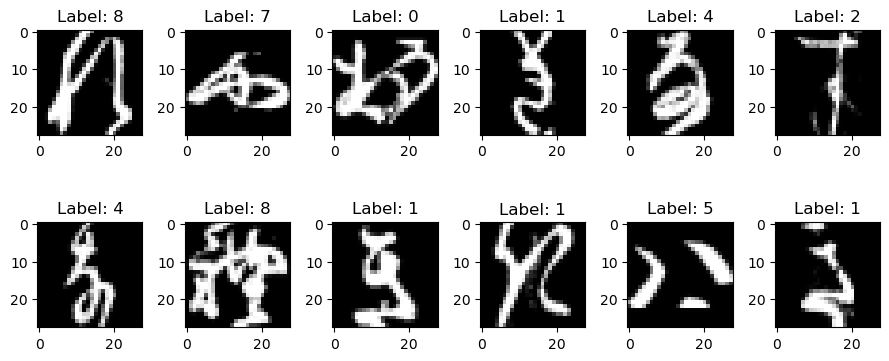

In [7]:
# Visualize first 12 samples of data
num_row = 2
num_col = 6

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(data.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(data.targets[i]))
plt.tight_layout()
plt.show()

In [8]:
data.data[0].shape 
# Each image is 28x28 with 1 channel only (greyscale), so a batch is BS X 28 X 28

torch.Size([28, 28])

In [9]:
# Use hold-out method on train dataset for train-validation splitting. Proportion is 70-30
from torch.utils.data.sampler import SubsetRandomSampler

N = len(data)
idx = list(range(N))

train_size = int(np.floor(N * 0.7))

shuffle_dataset = True
if shuffle_dataset:
    np.random.seed(42)
    np.random.shuffle(idx)

train_idx, val_idx = idx[:train_size], idx[train_size:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size = BS, sampler=train_idx)
val_loader = torch.utils.data.DataLoader(data, batch_size = BS, sampler=val_idx)


# Modelling

## CNNs

In [10]:
class CNN(nn.Module):
    def __init__(self, regularize=False, regularize_param = 0.2, fine_tuning = False):
        super().__init__()

        # Convolution Layer 1: BS x 28 x 28 -> BS X 28 x 28 x 3
        self.conv_layer_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=0, dilation=1, groups=1)

        # Pooling: BS X 26 x 26 x 3 -> BS x 13 x 13 x 3
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 1: BS x 13 x 13 x 3 -> BS x 255
        self.hidden_1 = nn.Linear(13*13*3, 255)

        # Layer 2: BS x 255 -> 10
        self.hidden_2 = nn.Linear(255, 10)

        self.regularize = regularize # boolean value
        if self.regularize:
            self.dropout = torch.nn.Dropout(p=regularize_param)
            self.fine_tuning = fine_tuning


    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.pool_1(x)
        x = F.relu(x)
        x = x.flatten(start_dim=1)

        if self.regularize and not self.fine_tuning:
            x = self.dropout(x)
            

        x = self.hidden_1(x)
        x = F.relu(x)

        if self.regularize and self.fine_tuning:
            x = self.dropout(x)

        x = self.hidden_2(x)
        x = F.relu(x)

        return x 

## FCNNs

In [11]:
class FCNN(nn.Module):
    def __init__(self, regularize=False, regularize_param = 0.2, fine_tuning = False):
        super().__init__()

        self.layer_1 = nn.Linear(28*28, 1024)
        self.layer_2 = nn.Linear(1024, 2048)
        self.layer_3 = nn.Linear(2048, 512)
        self.out = nn.Linear(512, 10)

        self.regularize = regularize # boolean value
        if self.regularize:
            self.dropout = torch.nn.Dropout(p=regularize_param)
            self.fine_tuning = fine_tuning


    def forward(self, x):
        x = x.flatten(start_dim=1)
        
        if self.regularize and not self.fine_tuning:
            x = self.dropout(x)


        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.tanh(x)

        if self.regularize and self.fine_tuning:
            x = self.dropout(x)


        x = self.layer_3(x)
        x = F.relu(x)
        x = self.out(x)

        return x

## Define Auxiliary Functions (define the training logic, testing logic, and get confusion matrix)

In [12]:
# functions

def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    losses = []
    print("TRAINING MODEL!")

    for epoch in (range(num_epochs)):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in tqdm(enumerate(trainloader)):
            
            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)
        
            
        losses.append(train_running_loss / i)
        model.eval()

        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}") 
    
    return losses

In [13]:
def test_model(model, valloader, criterion):
    # get losses on test dataset

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    running_loss = 0
    print("EVALUATING MODEL LOSS!")
    model = model.eval()

    start = time()
    ## training step
    for i, (images, labels) in tqdm(enumerate(valloader)):
        
        images = images.to(device)
        labels = labels.to(device)

        ## fp -> loss
        logits = model(images)
        loss = criterion(logits, labels)

        # Reset the gradients to zero
        ## update model params

        running_loss += loss.item()
        
            

    print(f"Average Loss: {running_loss/i} | Time: {time()-start:.2f}") 
    
    return running_loss/i

In [14]:
import sklearn.metrics 

def val_model(model, valloader, data):
    # Obs. data parameter is just to get the number of classes

    model.eval() # Sets to evaluation mode: i'm basically just freezing the gradients

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize empty confusion matrix
    CLASSES = data.targets.unique()

    CLASSES = CLASSES.to(device)
    
    N_CLASSES = CLASSES.shape[0]

    my_confusion_matrix = torch.zeros((N_CLASSES, N_CLASSES))

    print("EVALUATING MODEL")
    for images, labels in tqdm(valloader):
        images = images.to(device)
        labels = labels.to(device)
        
        y_hat = model(images)
        y_pred = torch.argmax(y_hat, dim=1)

        # Copy to CPU memory since i'm going to use sklearn (idk)
        labels_ = labels.cpu()
        y_pred_ = y_pred.cpu()
        CLASSES_= CLASSES.cpu()

        cm_i = sklearn.metrics.confusion_matrix(labels_, y_pred_, labels=CLASSES_)

        my_confusion_matrix += cm_i
    
    return my_confusion_matrix

In [ ]:
def save_model(model, loss, model_name):
    """Saves neural network's weights and his loss during training phase.
    
    Used for preservation purposes, incase I need to reuse models/losses for some reason."""

    fname_weights = f"./weights/{model_name}"
    fname_loss = f"./losses/{model_name}_loss.csv"

    try:
        torch.save(model.state_dict(), fname_weights)
        np.savetxt(fname_loss, loss, delimiter=',', fmt='%.16f')
    except Exception as e:
        return (-1, e)
    else:
        return 1


# Model Training

In [18]:
CE = nn.CrossEntropyLoss() # Define Loss function to optimize


In [33]:
my_cnn = CNN()

cnn_optimizer1 = torch.optim.Adam(my_cnn.parameters())

cnn_loss1 = train_model(my_cnn, 25, train_loader, CE, cnn_optimizer1)

TRAINING MODEL!


329it [00:04, 65.93it/s]


Epoch: 1 | Loss: 0.9108 | Train Accuracy: 71.6868 | Time: 5.00


329it [00:05, 65.46it/s]


Epoch: 2 | Loss: 0.6224 | Train Accuracy: 78.7371 | Time: 5.03


329it [00:05, 63.80it/s]


Epoch: 3 | Loss: 0.5227 | Train Accuracy: 81.5263 | Time: 5.16


329it [00:04, 67.55it/s]


Epoch: 4 | Loss: 0.4695 | Train Accuracy: 82.9792 | Time: 4.87


329it [00:04, 65.88it/s]


Epoch: 5 | Loss: 0.4039 | Train Accuracy: 85.4111 | Time: 5.00


329it [00:05, 63.74it/s]


Epoch: 6 | Loss: 0.3541 | Train Accuracy: 87.0546 | Time: 5.17


329it [00:05, 65.12it/s]


Epoch: 7 | Loss: 0.3346 | Train Accuracy: 87.5881 | Time: 5.06


329it [00:05, 63.81it/s]


Epoch: 8 | Loss: 0.3196 | Train Accuracy: 88.0073 | Time: 5.16


329it [00:05, 64.35it/s]


Epoch: 9 | Loss: 0.3074 | Train Accuracy: 88.3432 | Time: 5.12


329it [00:05, 65.25it/s]


Epoch: 10 | Loss: 0.2971 | Train Accuracy: 88.6147 | Time: 5.04


329it [00:05, 63.58it/s]


Epoch: 11 | Loss: 0.2916 | Train Accuracy: 88.6790 | Time: 5.18


329it [00:05, 63.83it/s]


Epoch: 12 | Loss: 0.2834 | Train Accuracy: 88.9339 | Time: 5.16


329it [00:05, 63.48it/s]


Epoch: 13 | Loss: 0.2778 | Train Accuracy: 89.0220 | Time: 5.19


329it [00:05, 62.69it/s]


Epoch: 14 | Loss: 0.2772 | Train Accuracy: 89.0696 | Time: 5.25


329it [00:05, 64.93it/s]


Epoch: 15 | Loss: 0.2716 | Train Accuracy: 89.1649 | Time: 5.07


329it [00:05, 63.17it/s]


Epoch: 16 | Loss: 0.2646 | Train Accuracy: 89.3936 | Time: 5.21


329it [00:05, 63.19it/s]


Epoch: 17 | Loss: 0.2592 | Train Accuracy: 89.4984 | Time: 5.21


329it [00:05, 61.56it/s]


Epoch: 18 | Loss: 0.2599 | Train Accuracy: 89.4507 | Time: 5.35


329it [00:05, 61.62it/s]


Epoch: 19 | Loss: 0.2559 | Train Accuracy: 89.5675 | Time: 5.34


329it [00:05, 64.86it/s]


Epoch: 20 | Loss: 0.2571 | Train Accuracy: 89.5151 | Time: 5.08


329it [00:05, 63.59it/s]


Epoch: 21 | Loss: 0.2602 | Train Accuracy: 89.4841 | Time: 5.18


329it [00:05, 65.11it/s]


Epoch: 22 | Loss: 0.2539 | Train Accuracy: 89.6032 | Time: 5.06


329it [00:05, 64.50it/s]


Epoch: 23 | Loss: 0.2493 | Train Accuracy: 89.7175 | Time: 5.10


329it [00:05, 63.44it/s]


Epoch: 24 | Loss: 0.2482 | Train Accuracy: 89.7485 | Time: 5.19


329it [00:05, 64.03it/s]

Epoch: 25 | Loss: 0.2482 | Train Accuracy: 89.7532 | Time: 5.14


In [34]:
save_model(my_cnn, cnn_loss1, "first_cnn")

1

In [49]:
my_cnn_again = CNN()

CE = nn.CrossEntropyLoss()
cnn_optimizer1 = torch.optim.Adam(my_cnn_again.parameters())

cnn_loss2 = train_model(my_cnn_again, 25, train_loader, CE, cnn_optimizer1)

save_model(my_cnn_again, cnn_loss2, "second_cnn")

TRAINING MODEL!


329it [00:06, 54.32it/s]


Epoch: 1 | Loss: 1.7860 | Train Accuracy: 38.5147 | Time: 6.06


329it [00:05, 55.46it/s]


Epoch: 2 | Loss: 1.6108 | Train Accuracy: 43.8834 | Time: 5.94


329it [00:06, 52.62it/s]


Epoch: 3 | Loss: 1.5540 | Train Accuracy: 45.2982 | Time: 6.26


329it [00:06, 51.69it/s]


Epoch: 4 | Loss: 1.5216 | Train Accuracy: 46.1414 | Time: 6.37


329it [00:06, 53.43it/s]


Epoch: 5 | Loss: 1.5017 | Train Accuracy: 46.5749 | Time: 6.16


329it [00:06, 52.39it/s]


Epoch: 6 | Loss: 1.3976 | Train Accuracy: 50.7789 | Time: 6.28


329it [00:05, 54.98it/s]


Epoch: 7 | Loss: 1.3263 | Train Accuracy: 53.6847 | Time: 5.99


329it [00:05, 56.75it/s]


Epoch: 8 | Loss: 1.3145 | Train Accuracy: 53.9682 | Time: 5.80


329it [00:05, 63.56it/s]


Epoch: 9 | Loss: 1.3073 | Train Accuracy: 54.1087 | Time: 5.18


329it [00:05, 63.63it/s]


Epoch: 10 | Loss: 1.3010 | Train Accuracy: 54.2540 | Time: 5.18


329it [00:05, 63.60it/s]


Epoch: 11 | Loss: 1.2961 | Train Accuracy: 54.3683 | Time: 5.18


329it [00:05, 63.72it/s]


Epoch: 12 | Loss: 1.2919 | Train Accuracy: 54.4422 | Time: 5.17


329it [00:05, 63.41it/s]


Epoch: 13 | Loss: 1.2888 | Train Accuracy: 54.5446 | Time: 5.19


329it [00:04, 65.88it/s]


Epoch: 14 | Loss: 1.2861 | Train Accuracy: 54.6137 | Time: 5.00


329it [00:05, 63.44it/s]


Epoch: 15 | Loss: 1.2844 | Train Accuracy: 54.6589 | Time: 5.19


329it [00:05, 61.03it/s]


Epoch: 16 | Loss: 1.2839 | Train Accuracy: 54.7042 | Time: 5.39


329it [00:05, 62.24it/s]


Epoch: 17 | Loss: 1.2818 | Train Accuracy: 54.7875 | Time: 5.29


329it [00:05, 60.46it/s]


Epoch: 18 | Loss: 1.2808 | Train Accuracy: 54.8280 | Time: 5.45


329it [00:05, 61.93it/s]


Epoch: 19 | Loss: 1.2781 | Train Accuracy: 54.9376 | Time: 5.32


329it [00:05, 61.65it/s]


Epoch: 20 | Loss: 1.2748 | Train Accuracy: 54.9852 | Time: 5.34


329it [00:05, 61.89it/s]


Epoch: 21 | Loss: 1.2739 | Train Accuracy: 55.0257 | Time: 5.32


329it [00:05, 62.42it/s]


Epoch: 22 | Loss: 1.2729 | Train Accuracy: 55.0710 | Time: 5.27


329it [00:04, 66.49it/s]


Epoch: 23 | Loss: 1.2290 | Train Accuracy: 57.3028 | Time: 4.95


329it [00:04, 66.49it/s]


Epoch: 24 | Loss: 1.2118 | Train Accuracy: 57.8768 | Time: 4.95


329it [00:05, 62.83it/s]

Epoch: 25 | Loss: 1.2076 | Train Accuracy: 57.9697 | Time: 5.24


1

In [50]:
# Notice how the results have drastically changed, meaning that the problem is likely non-convex and the initialization may be a crucial step.
cnn_normal = CNN()
cnn_zeros = CNN()
cnn_dirac = CNN()
cnn_xavier = CNN()

torch.nn.init.normal_(cnn_normal.conv_layer_1.weight)
torch.nn.init.zeros_(cnn_zeros.conv_layer_1.weight)
torch.nn.init.dirac_(cnn_dirac.conv_layer_1.weight)
torch.nn.init.xavier_uniform_(cnn_xavier.conv_layer_1.weight)


Parameter containing:
tensor([[[[ 0.0498, -0.0190,  0.2394],
          [-0.0998, -0.0610, -0.0396],
          [-0.0912,  0.0598, -0.0170]]],


        [[[-0.0549,  0.3115,  0.3436],
          [ 0.2003,  0.3932, -0.0043],
          [ 0.1718,  0.3190,  0.2463]]],


        [[[-0.1596, -0.3919, -0.0341],
          [-0.0800, -0.2021,  0.3503],
          [-0.2815,  0.1800, -0.0646]]]], requires_grad=True)

In [51]:
models = [cnn_normal, cnn_zeros, cnn_dirac, cnn_xavier]

renamer = {
    cnn_normal: 'cnn normal',
    cnn_zeros: 'cnn zeros',
    cnn_dirac: 'cnn dirac',
    cnn_xavier: 'xavier'
}

losses = {}

In [53]:
for model in models:  
    print(renamer[model])
    losses[renamer[model]] = train_model(model, 25, train_loader, CE, torch.optim.Adam(model.parameters()))

    save_model(model, losses[renamer[model]], renamer[model].replace(" ", "_"))
    print("="*80)
    print()
    pass


cnn normal
TRAINING MODEL!


329it [00:06, 51.36it/s]


Epoch: 1 | Loss: 0.4837 | Train Accuracy: 79.5898 | Time: 6.41


329it [00:05, 56.30it/s]


Epoch: 2 | Loss: 0.4820 | Train Accuracy: 79.5994 | Time: 5.85


329it [00:05, 59.84it/s]


Epoch: 3 | Loss: 0.4787 | Train Accuracy: 79.6923 | Time: 5.50


329it [00:05, 58.35it/s]


Epoch: 4 | Loss: 0.4804 | Train Accuracy: 79.6446 | Time: 5.64


329it [00:05, 59.90it/s]


Epoch: 5 | Loss: 0.4790 | Train Accuracy: 79.7304 | Time: 5.50


329it [00:05, 64.20it/s]


Epoch: 6 | Loss: 0.4776 | Train Accuracy: 79.7137 | Time: 5.13


329it [00:05, 65.33it/s]


Epoch: 7 | Loss: 0.4774 | Train Accuracy: 79.7328 | Time: 5.04


329it [00:05, 64.55it/s]


Epoch: 8 | Loss: 0.4780 | Train Accuracy: 79.7208 | Time: 5.10


329it [00:04, 66.18it/s]


Epoch: 9 | Loss: 0.4785 | Train Accuracy: 79.6827 | Time: 4.98


329it [00:05, 65.64it/s]


Epoch: 10 | Loss: 0.4763 | Train Accuracy: 79.7375 | Time: 5.02


329it [00:04, 67.82it/s]


Epoch: 11 | Loss: 0.4798 | Train Accuracy: 79.6756 | Time: 4.85


329it [00:04, 66.16it/s]


Epoch: 12 | Loss: 0.4773 | Train Accuracy: 79.7447 | Time: 4.98


329it [00:04, 66.11it/s]


Epoch: 13 | Loss: 0.4752 | Train Accuracy: 79.7899 | Time: 4.98


329it [00:05, 63.53it/s]


Epoch: 14 | Loss: 0.4726 | Train Accuracy: 79.8399 | Time: 5.18


329it [00:10, 32.02it/s]


Epoch: 15 | Loss: 0.4721 | Train Accuracy: 79.8447 | Time: 10.28


329it [00:05, 63.20it/s]


Epoch: 16 | Loss: 0.4718 | Train Accuracy: 79.8447 | Time: 5.21


329it [00:05, 65.14it/s]


Epoch: 17 | Loss: 0.4718 | Train Accuracy: 79.8447 | Time: 5.05


329it [00:05, 65.69it/s]


Epoch: 18 | Loss: 0.4718 | Train Accuracy: 79.8447 | Time: 5.01


329it [00:05, 64.99it/s]


Epoch: 19 | Loss: 0.4718 | Train Accuracy: 79.8447 | Time: 5.07


329it [00:05, 63.68it/s]


Epoch: 20 | Loss: 0.4957 | Train Accuracy: 79.3540 | Time: 5.17


329it [00:04, 66.52it/s]


Epoch: 21 | Loss: 0.4805 | Train Accuracy: 79.6232 | Time: 4.95


329it [00:05, 63.83it/s]


Epoch: 22 | Loss: 0.4736 | Train Accuracy: 79.8090 | Time: 5.16


329it [00:04, 66.48it/s]


Epoch: 23 | Loss: 0.4724 | Train Accuracy: 79.8423 | Time: 4.95


329it [00:04, 66.28it/s]


Epoch: 24 | Loss: 0.4718 | Train Accuracy: 79.8495 | Time: 4.97


329it [00:04, 66.13it/s]


Epoch: 25 | Loss: 0.4717 | Train Accuracy: 79.8495 | Time: 4.98

cnn zeros
TRAINING MODEL!


329it [00:05, 59.72it/s]


Epoch: 1 | Loss: 2.3097 | Train Accuracy: 10.0348 | Time: 5.51


329it [00:08, 40.57it/s]


Epoch: 2 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 8.11


329it [00:06, 47.78it/s]


Epoch: 3 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 6.89


329it [00:06, 51.23it/s]


Epoch: 4 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 6.43


329it [00:05, 59.05it/s]


Epoch: 5 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.58


329it [00:05, 59.32it/s]


Epoch: 6 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.55


329it [00:05, 58.93it/s]


Epoch: 7 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.59


329it [00:05, 59.43it/s]


Epoch: 8 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.54


329it [00:05, 58.64it/s]


Epoch: 9 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.62


329it [00:05, 59.27it/s]


Epoch: 10 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.55


329it [00:06, 49.44it/s]


Epoch: 11 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 6.66


329it [00:08, 38.86it/s]


Epoch: 12 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 8.47


329it [00:08, 39.74it/s]


Epoch: 13 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 8.28


329it [00:06, 50.38it/s]


Epoch: 14 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 6.54


329it [00:05, 55.49it/s]


Epoch: 15 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.93


329it [00:05, 59.37it/s]


Epoch: 16 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.55


329it [00:05, 56.03it/s]


Epoch: 17 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.88


329it [00:06, 54.02it/s]


Epoch: 18 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 6.09


329it [00:05, 62.41it/s]


Epoch: 19 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.27


329it [00:04, 65.86it/s]


Epoch: 20 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.00


329it [00:05, 58.02it/s]


Epoch: 21 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.67


329it [00:05, 65.20it/s]


Epoch: 22 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 5.05


329it [00:04, 66.98it/s]


Epoch: 23 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 4.92


329it [00:04, 66.69it/s]


Epoch: 24 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 4.94


329it [00:04, 67.58it/s]


Epoch: 25 | Loss: 2.3096 | Train Accuracy: 9.9466 | Time: 4.87

cnn dirac
TRAINING MODEL!


329it [00:05, 65.72it/s]


Epoch: 1 | Loss: 1.1322 | Train Accuracy: 68.6547 | Time: 5.01


329it [00:05, 65.21it/s]


Epoch: 2 | Loss: 0.8212 | Train Accuracy: 78.6085 | Time: 5.05


329it [00:06, 53.24it/s]


Epoch: 3 | Loss: 0.7310 | Train Accuracy: 81.5215 | Time: 6.18


329it [00:07, 46.57it/s]


Epoch: 4 | Loss: 0.6795 | Train Accuracy: 83.2555 | Time: 7.07


329it [00:06, 54.24it/s]


Epoch: 5 | Loss: 0.6318 | Train Accuracy: 84.8561 | Time: 6.07


329it [00:05, 55.21it/s]


Epoch: 6 | Loss: 0.6053 | Train Accuracy: 85.6779 | Time: 5.96


329it [00:05, 55.15it/s]


Epoch: 7 | Loss: 0.5857 | Train Accuracy: 86.2305 | Time: 5.97


329it [00:05, 55.77it/s]


Epoch: 8 | Loss: 0.5707 | Train Accuracy: 86.7950 | Time: 5.90


329it [00:06, 54.65it/s]


Epoch: 9 | Loss: 0.5578 | Train Accuracy: 87.1689 | Time: 6.03


329it [00:06, 54.32it/s]


Epoch: 10 | Loss: 0.5476 | Train Accuracy: 87.4714 | Time: 6.06


329it [00:05, 56.44it/s]


Epoch: 11 | Loss: 0.5396 | Train Accuracy: 87.6834 | Time: 5.83


329it [00:05, 62.58it/s]


Epoch: 12 | Loss: 0.5325 | Train Accuracy: 87.8668 | Time: 5.26


329it [00:04, 66.10it/s]


Epoch: 13 | Loss: 0.5263 | Train Accuracy: 88.0407 | Time: 4.98


329it [00:04, 67.99it/s]


Epoch: 14 | Loss: 0.5223 | Train Accuracy: 88.1455 | Time: 4.84


329it [00:04, 66.30it/s]


Epoch: 15 | Loss: 0.5186 | Train Accuracy: 88.2074 | Time: 4.97


329it [00:05, 65.65it/s]


Epoch: 16 | Loss: 0.5145 | Train Accuracy: 88.2884 | Time: 5.02


329it [00:05, 64.73it/s]


Epoch: 17 | Loss: 0.5130 | Train Accuracy: 88.4003 | Time: 5.09


329it [00:05, 62.86it/s]


Epoch: 18 | Loss: 0.5068 | Train Accuracy: 88.5957 | Time: 5.24


329it [00:05, 64.60it/s]


Epoch: 19 | Loss: 0.5063 | Train Accuracy: 88.5409 | Time: 5.10


329it [00:05, 65.79it/s]


Epoch: 20 | Loss: 0.5046 | Train Accuracy: 88.6528 | Time: 5.00


329it [00:05, 65.00it/s]


Epoch: 21 | Loss: 0.5012 | Train Accuracy: 88.7052 | Time: 5.06


329it [00:04, 66.81it/s]


Epoch: 22 | Loss: 0.4995 | Train Accuracy: 88.8076 | Time: 4.93


329it [00:05, 65.40it/s]


Epoch: 23 | Loss: 0.4968 | Train Accuracy: 88.8910 | Time: 5.03


329it [00:04, 66.20it/s]


Epoch: 24 | Loss: 0.4961 | Train Accuracy: 88.8720 | Time: 4.97


329it [00:04, 66.16it/s]


Epoch: 25 | Loss: 0.4948 | Train Accuracy: 88.9577 | Time: 4.98

xavier
TRAINING MODEL!


329it [00:04, 66.05it/s]


Epoch: 1 | Loss: 1.6821 | Train Accuracy: 33.8415 | Time: 4.98


329it [00:05, 62.65it/s]


Epoch: 2 | Loss: 1.5800 | Train Accuracy: 35.0776 | Time: 5.25


329it [00:05, 62.96it/s]


Epoch: 3 | Loss: 1.5487 | Train Accuracy: 35.5897 | Time: 5.23


329it [00:05, 63.23it/s]


Epoch: 4 | Loss: 1.5278 | Train Accuracy: 35.9970 | Time: 5.21


329it [00:05, 57.51it/s]


Epoch: 5 | Loss: 1.5139 | Train Accuracy: 36.2281 | Time: 5.72


329it [00:07, 42.57it/s]


Epoch: 6 | Loss: 1.5036 | Train Accuracy: 36.4163 | Time: 7.73


329it [00:07, 45.32it/s]


Epoch: 7 | Loss: 1.4950 | Train Accuracy: 36.5639 | Time: 7.26


329it [00:06, 50.29it/s]


Epoch: 8 | Loss: 1.4880 | Train Accuracy: 36.7045 | Time: 6.55


329it [00:05, 56.64it/s]


Epoch: 9 | Loss: 1.4824 | Train Accuracy: 36.8069 | Time: 5.81


329it [00:05, 55.73it/s]


Epoch: 10 | Loss: 1.4780 | Train Accuracy: 36.8426 | Time: 5.91


329it [00:06, 51.22it/s]


Epoch: 11 | Loss: 1.4596 | Train Accuracy: 37.7620 | Time: 6.43


329it [00:05, 55.63it/s]


Epoch: 12 | Loss: 1.4188 | Train Accuracy: 39.5865 | Time: 5.92


329it [00:05, 55.52it/s]


Epoch: 13 | Loss: 1.4106 | Train Accuracy: 39.7080 | Time: 5.93


329it [00:05, 56.04it/s]


Epoch: 14 | Loss: 1.4058 | Train Accuracy: 39.7628 | Time: 5.87


329it [00:05, 56.21it/s]


Epoch: 15 | Loss: 1.4045 | Train Accuracy: 39.8128 | Time: 5.86


329it [00:05, 55.99it/s]


Epoch: 16 | Loss: 1.4035 | Train Accuracy: 39.7913 | Time: 5.88


329it [00:05, 55.53it/s]


Epoch: 17 | Loss: 1.4009 | Train Accuracy: 39.8247 | Time: 5.93


329it [00:05, 55.48it/s]


Epoch: 18 | Loss: 1.3985 | Train Accuracy: 39.8652 | Time: 5.93


329it [00:05, 56.30it/s]


Epoch: 19 | Loss: 1.3981 | Train Accuracy: 39.8533 | Time: 5.85


329it [00:05, 62.45it/s]


Epoch: 20 | Loss: 1.3964 | Train Accuracy: 39.8819 | Time: 5.27


329it [00:04, 66.69it/s]


Epoch: 21 | Loss: 1.3964 | Train Accuracy: 39.8842 | Time: 4.94


329it [00:04, 67.23it/s]


Epoch: 22 | Loss: 1.3956 | Train Accuracy: 39.9033 | Time: 4.90


329it [00:04, 66.31it/s]


Epoch: 23 | Loss: 1.3976 | Train Accuracy: 39.8700 | Time: 4.97


329it [00:05, 65.23it/s]


Epoch: 24 | Loss: 1.4008 | Train Accuracy: 39.8533 | Time: 5.05


329it [00:04, 67.97it/s]

Epoch: 25 | Loss: 1.3950 | Train Accuracy: 39.9057 | Time: 4.85



In [55]:
# Let's try SGD as a final restort
cnn_sgd = CNN()

CE = nn.CrossEntropyLoss()
cnn_optimizer_sgd = torch.optim.SGD(cnn_sgd.parameters())

cnn_loss_sgd_1 = train_model(cnn_sgd, 25, train_loader, CE, cnn_optimizer_sgd)

save_model(cnn_sgd, cnn_loss_sgd_1, 'cnn_sgd_part1')

TRAINING MODEL!


329it [00:07, 43.98it/s]


Epoch: 1 | Loss: 2.3087 | Train Accuracy: 10.5493 | Time: 7.48


329it [00:07, 44.74it/s]


Epoch: 2 | Loss: 2.3050 | Train Accuracy: 11.8879 | Time: 7.36


329it [00:08, 38.25it/s]


Epoch: 3 | Loss: 2.2979 | Train Accuracy: 16.0752 | Time: 8.61


329it [00:07, 43.29it/s]


Epoch: 4 | Loss: 2.2873 | Train Accuracy: 26.5458 | Time: 7.61


329it [00:05, 55.87it/s]


Epoch: 5 | Loss: 2.2726 | Train Accuracy: 36.4067 | Time: 5.89


329it [00:05, 58.56it/s]


Epoch: 6 | Loss: 2.2495 | Train Accuracy: 42.3233 | Time: 5.62


329it [00:05, 61.00it/s]


Epoch: 7 | Loss: 2.2125 | Train Accuracy: 45.5840 | Time: 5.40


329it [00:05, 55.23it/s]


Epoch: 8 | Loss: 2.1520 | Train Accuracy: 47.8420 | Time: 5.96


329it [00:08, 39.78it/s]


Epoch: 9 | Loss: 2.0557 | Train Accuracy: 50.3573 | Time: 8.27


329it [00:05, 56.76it/s]


Epoch: 10 | Loss: 1.9162 | Train Accuracy: 54.1087 | Time: 5.80


329it [00:05, 56.98it/s]


Epoch: 11 | Loss: 1.7457 | Train Accuracy: 58.6795 | Time: 5.78


329it [00:05, 55.96it/s]


Epoch: 12 | Loss: 1.5841 | Train Accuracy: 62.0998 | Time: 5.88


329it [00:05, 57.23it/s]


Epoch: 13 | Loss: 1.4499 | Train Accuracy: 64.0363 | Time: 5.75


329it [00:06, 52.87it/s]


Epoch: 14 | Loss: 1.3446 | Train Accuracy: 65.3344 | Time: 6.23


329it [00:05, 56.68it/s]


Epoch: 15 | Loss: 1.2621 | Train Accuracy: 66.4610 | Time: 5.81


329it [00:05, 59.67it/s]


Epoch: 16 | Loss: 1.1961 | Train Accuracy: 67.3185 | Time: 5.52


329it [00:05, 61.75it/s]


Epoch: 17 | Loss: 1.1423 | Train Accuracy: 68.0998 | Time: 5.33


329it [00:05, 63.00it/s]


Epoch: 18 | Loss: 1.0977 | Train Accuracy: 68.8095 | Time: 5.22


329it [00:05, 63.67it/s]


Epoch: 19 | Loss: 1.0604 | Train Accuracy: 69.4550 | Time: 5.17


329it [00:05, 65.64it/s]


Epoch: 20 | Loss: 1.0286 | Train Accuracy: 70.0148 | Time: 5.02


329it [00:05, 65.50it/s]


Epoch: 21 | Loss: 1.0012 | Train Accuracy: 70.5197 | Time: 5.03


329it [00:05, 65.16it/s]


Epoch: 22 | Loss: 0.9771 | Train Accuracy: 71.0580 | Time: 5.05


329it [00:05, 57.84it/s]


Epoch: 23 | Loss: 0.9556 | Train Accuracy: 71.5034 | Time: 5.69


329it [00:05, 64.89it/s]


Epoch: 24 | Loss: 0.9363 | Train Accuracy: 71.8917 | Time: 5.07


329it [00:08, 40.55it/s]

Epoch: 25 | Loss: 0.9189 | Train Accuracy: 72.3347 | Time: 8.12


1

In [56]:
# Continue training with bigger lr
cnn_optimizer_sgd = torch.optim.SGD(cnn_sgd.parameters(), lr=0.05)

cnn_loss_sgd_2 = train_model(cnn_sgd, 25, train_loader, CE, cnn_optimizer_sgd)
save_model(cnn_sgd, cnn_loss_sgd_2, 'cnn_sgd_part2')

TRAINING MODEL!


329it [00:07, 46.67it/s]


Epoch: 1 | Loss: 0.6809 | Train Accuracy: 78.9420 | Time: 7.06


329it [00:07, 41.82it/s]


Epoch: 2 | Loss: 0.3423 | Train Accuracy: 89.8914 | Time: 7.87


329it [00:08, 39.26it/s]


Epoch: 3 | Loss: 0.2552 | Train Accuracy: 92.6734 | Time: 8.39


329it [00:08, 39.51it/s]


Epoch: 4 | Loss: 0.2062 | Train Accuracy: 94.1859 | Time: 8.33


329it [00:08, 40.78it/s]


Epoch: 5 | Loss: 0.1737 | Train Accuracy: 95.1529 | Time: 8.07


329it [00:08, 39.94it/s]


Epoch: 6 | Loss: 0.1501 | Train Accuracy: 95.8818 | Time: 8.24


329it [00:08, 39.49it/s]


Epoch: 7 | Loss: 0.1316 | Train Accuracy: 96.5106 | Time: 8.34


329it [00:08, 40.24it/s]


Epoch: 8 | Loss: 0.1166 | Train Accuracy: 96.9465 | Time: 8.18


329it [00:07, 41.55it/s]


Epoch: 9 | Loss: 0.1038 | Train Accuracy: 97.2847 | Time: 7.92


329it [00:07, 41.21it/s]


Epoch: 10 | Loss: 0.0927 | Train Accuracy: 97.6944 | Time: 7.99


329it [00:07, 42.88it/s]


Epoch: 11 | Loss: 0.0834 | Train Accuracy: 97.9945 | Time: 7.68


329it [00:07, 42.49it/s]


Epoch: 12 | Loss: 0.0746 | Train Accuracy: 98.2827 | Time: 7.75


329it [00:08, 40.43it/s]


Epoch: 13 | Loss: 0.0671 | Train Accuracy: 98.4566 | Time: 8.14


329it [00:08, 40.31it/s]


Epoch: 14 | Loss: 0.0599 | Train Accuracy: 98.7043 | Time: 8.17


329it [00:08, 40.03it/s]


Epoch: 15 | Loss: 0.0534 | Train Accuracy: 98.9591 | Time: 8.23


329it [00:08, 39.11it/s]


Epoch: 16 | Loss: 0.0474 | Train Accuracy: 99.1783 | Time: 8.42


329it [00:08, 39.32it/s]


Epoch: 17 | Loss: 0.0423 | Train Accuracy: 99.3760 | Time: 8.37


329it [00:08, 38.67it/s]


Epoch: 18 | Loss: 0.0373 | Train Accuracy: 99.5022 | Time: 8.51


329it [00:07, 42.00it/s]


Epoch: 19 | Loss: 0.0332 | Train Accuracy: 99.6260 | Time: 7.84


329it [00:07, 44.86it/s]


Epoch: 20 | Loss: 0.0295 | Train Accuracy: 99.7451 | Time: 7.34


329it [00:08, 40.17it/s]


Epoch: 21 | Loss: 0.0264 | Train Accuracy: 99.8452 | Time: 8.20


329it [00:08, 39.99it/s]


Epoch: 22 | Loss: 0.0235 | Train Accuracy: 99.9262 | Time: 8.23


329it [00:07, 41.24it/s]


Epoch: 23 | Loss: 0.0211 | Train Accuracy: 99.9786 | Time: 7.98


329it [00:08, 37.67it/s]


Epoch: 24 | Loss: 0.0190 | Train Accuracy: 100.0286 | Time: 8.74


329it [00:08, 40.15it/s]

Epoch: 25 | Loss: 0.0171 | Train Accuracy: 100.0691 | Time: 8.20


1

In [83]:
# now let's try FCNNs, using adam optimizer

first_fcnn = FCNN()

fcnn_adam = torch.optim.Adam(first_fcnn.parameters())

fcnn_loss_adam = train_model(first_fcnn, 25, train_loader, CE, fcnn_adam)

save_model(first_fcnn, fcnn_loss_adam, "fcnn_adam")

TRAINING MODEL!


329it [00:06, 53.96it/s]


Epoch: 1 | Loss: 0.3835 | Train Accuracy: 88.5099 | Time: 6.10


329it [00:05, 56.38it/s]


Epoch: 2 | Loss: 0.1562 | Train Accuracy: 95.6102 | Time: 5.84


329it [00:05, 57.40it/s]


Epoch: 3 | Loss: 0.1035 | Train Accuracy: 97.1727 | Time: 5.74


329it [00:05, 57.48it/s]


Epoch: 4 | Loss: 0.0793 | Train Accuracy: 97.8182 | Time: 5.73


329it [00:05, 57.84it/s]


Epoch: 5 | Loss: 0.0672 | Train Accuracy: 98.2088 | Time: 5.69


329it [00:05, 55.98it/s]


Epoch: 6 | Loss: 0.0518 | Train Accuracy: 98.7257 | Time: 5.88


329it [00:05, 57.14it/s]


Epoch: 7 | Loss: 0.0435 | Train Accuracy: 98.9734 | Time: 5.76


329it [00:05, 55.84it/s]


Epoch: 8 | Loss: 0.0375 | Train Accuracy: 99.1235 | Time: 5.90


329it [00:05, 56.59it/s]


Epoch: 9 | Loss: 0.0378 | Train Accuracy: 99.1521 | Time: 5.82


329it [00:05, 57.83it/s]


Epoch: 10 | Loss: 0.0351 | Train Accuracy: 99.2545 | Time: 5.69


329it [00:05, 55.79it/s]


Epoch: 11 | Loss: 0.0277 | Train Accuracy: 99.5117 | Time: 5.90


329it [00:06, 54.76it/s]


Epoch: 12 | Loss: 0.0195 | Train Accuracy: 99.6403 | Time: 6.01


329it [00:05, 56.20it/s]


Epoch: 13 | Loss: 0.0279 | Train Accuracy: 99.5093 | Time: 5.86


329it [00:05, 56.43it/s]


Epoch: 14 | Loss: 0.0245 | Train Accuracy: 99.6237 | Time: 5.83


329it [00:05, 57.23it/s]


Epoch: 15 | Loss: 0.0217 | Train Accuracy: 99.6808 | Time: 5.75


329it [00:05, 56.99it/s]


Epoch: 16 | Loss: 0.0167 | Train Accuracy: 99.8047 | Time: 5.78


329it [00:06, 54.62it/s]


Epoch: 17 | Loss: 0.0125 | Train Accuracy: 99.8928 | Time: 6.03


329it [00:05, 55.24it/s]


Epoch: 18 | Loss: 0.0117 | Train Accuracy: 99.9857 | Time: 5.96


329it [00:06, 54.54it/s]


Epoch: 19 | Loss: 0.0231 | Train Accuracy: 99.6213 | Time: 6.04


329it [00:06, 54.68it/s]


Epoch: 20 | Loss: 0.0133 | Train Accuracy: 99.9071 | Time: 6.02


329it [00:05, 55.32it/s]


Epoch: 21 | Loss: 0.0108 | Train Accuracy: 99.9786 | Time: 5.95


329it [00:06, 54.69it/s]


Epoch: 22 | Loss: 0.0141 | Train Accuracy: 99.8952 | Time: 6.02


329it [00:05, 55.78it/s]


Epoch: 23 | Loss: 0.0148 | Train Accuracy: 99.9023 | Time: 5.90


329it [00:06, 54.32it/s]


Epoch: 24 | Loss: 0.0111 | Train Accuracy: 100.0048 | Time: 6.06


329it [00:05, 55.72it/s]

Epoch: 25 | Loss: 0.0114 | Train Accuracy: 99.9619 | Time: 5.91


1

In [63]:
# now let's try FCNNs, using adam optimizer

fcnn_sgd = FCNN()

fcnn_sgd_optimizer = torch.optim.SGD(fcnn_sgd.parameters())

fcnn_loss_sgd = train_model(fcnn_sgd, 25, train_loader, CE, fcnn_sgd_optimizer)

save_model(fcnn_sgd, fcnn_loss_sgd, "fcnn_sgd_part1")

TRAINING MODEL!


0it [00:00, ?it/s]

329it [00:08, 38.51it/s]


Epoch: 1 | Loss: 2.3036 | Train Accuracy: 12.0236 | Time: 8.55


329it [00:07, 42.94it/s]


Epoch: 2 | Loss: 2.2916 | Train Accuracy: 21.6082 | Time: 7.67


329it [00:08, 38.76it/s]


Epoch: 3 | Loss: 2.2787 | Train Accuracy: 34.1321 | Time: 8.49


329it [00:08, 39.72it/s]


Epoch: 4 | Loss: 2.2639 | Train Accuracy: 40.8799 | Time: 8.29


329it [00:05, 62.02it/s]


Epoch: 5 | Loss: 2.2467 | Train Accuracy: 44.0763 | Time: 5.31


329it [00:05, 59.40it/s]


Epoch: 6 | Loss: 2.2259 | Train Accuracy: 46.1938 | Time: 5.54


329it [00:05, 60.22it/s]


Epoch: 7 | Loss: 2.2007 | Train Accuracy: 47.3895 | Time: 5.47


329it [00:05, 63.89it/s]


Epoch: 8 | Loss: 2.1696 | Train Accuracy: 48.0088 | Time: 5.15


329it [00:05, 61.22it/s]


Epoch: 9 | Loss: 2.1315 | Train Accuracy: 48.3279 | Time: 5.38


329it [00:05, 62.39it/s]


Epoch: 10 | Loss: 2.0853 | Train Accuracy: 48.2208 | Time: 5.28


329it [00:05, 61.10it/s]


Epoch: 11 | Loss: 2.0309 | Train Accuracy: 48.0064 | Time: 5.39


329it [00:05, 61.00it/s]


Epoch: 12 | Loss: 1.9696 | Train Accuracy: 48.0802 | Time: 5.40


329it [00:05, 62.88it/s]


Epoch: 13 | Loss: 1.9044 | Train Accuracy: 48.7448 | Time: 5.24


329it [00:05, 61.97it/s]


Epoch: 14 | Loss: 1.8382 | Train Accuracy: 50.3978 | Time: 5.31


329it [00:05, 62.10it/s]


Epoch: 15 | Loss: 1.7730 | Train Accuracy: 53.0655 | Time: 5.30


329it [00:05, 58.94it/s]


Epoch: 16 | Loss: 1.7091 | Train Accuracy: 56.5620 | Time: 5.59


329it [00:05, 59.43it/s]


Epoch: 17 | Loss: 1.6460 | Train Accuracy: 60.1753 | Time: 5.54


329it [00:05, 61.72it/s]


Epoch: 18 | Loss: 1.5828 | Train Accuracy: 62.8525 | Time: 5.33


329it [00:05, 61.49it/s]


Epoch: 19 | Loss: 1.5192 | Train Accuracy: 64.7842 | Time: 5.35


329it [00:05, 62.14it/s]


Epoch: 20 | Loss: 1.4553 | Train Accuracy: 66.2872 | Time: 5.30


329it [00:05, 61.35it/s]


Epoch: 21 | Loss: 1.3920 | Train Accuracy: 67.4900 | Time: 5.37


329it [00:05, 59.07it/s]


Epoch: 22 | Loss: 1.3301 | Train Accuracy: 68.4022 | Time: 5.57


329it [00:05, 58.32it/s]


Epoch: 23 | Loss: 1.2709 | Train Accuracy: 69.1764 | Time: 5.64


329it [00:05, 60.22it/s]


Epoch: 24 | Loss: 1.2152 | Train Accuracy: 69.9314 | Time: 5.47


329it [00:05, 62.02it/s]

Epoch: 25 | Loss: 1.1635 | Train Accuracy: 70.4959 | Time: 5.31


1

In [64]:
# now let's try FCNNs, using adam optimizer

fcnn_sgd_optimizer2 = torch.optim.SGD(fcnn_sgd.parameters(), 0.05)

fcnn_loss_sgd_2 = train_model(fcnn_sgd, 25, train_loader, CE, fcnn_sgd_optimizer2)

save_model(fcnn_sgd, fcnn_loss_sgd_2, "fcnn_sgd_part2")

TRAINING MODEL!


329it [00:05, 62.00it/s]


Epoch: 1 | Loss: 0.7486 | Train Accuracy: 78.3179 | Time: 5.31


329it [00:05, 61.74it/s]


Epoch: 2 | Loss: 0.4945 | Train Accuracy: 85.2491 | Time: 5.33


329it [00:05, 61.75it/s]


Epoch: 3 | Loss: 0.3822 | Train Accuracy: 88.8219 | Time: 5.33


329it [00:05, 64.00it/s]


Epoch: 4 | Loss: 0.3070 | Train Accuracy: 91.1490 | Time: 5.14


329it [00:05, 60.63it/s]


Epoch: 5 | Loss: 0.2516 | Train Accuracy: 92.9187 | Time: 5.43


329it [00:05, 60.71it/s]


Epoch: 6 | Loss: 0.2079 | Train Accuracy: 94.3598 | Time: 5.42


329it [00:05, 62.71it/s]


Epoch: 7 | Loss: 0.1720 | Train Accuracy: 95.5650 | Time: 5.25


329it [00:05, 59.67it/s]


Epoch: 8 | Loss: 0.1422 | Train Accuracy: 96.5201 | Time: 5.52


329it [00:05, 57.66it/s]


Epoch: 9 | Loss: 0.1174 | Train Accuracy: 97.2823 | Time: 5.71


329it [00:05, 61.97it/s]


Epoch: 10 | Loss: 0.0966 | Train Accuracy: 97.8968 | Time: 5.31


329it [00:05, 63.84it/s]


Epoch: 11 | Loss: 0.0787 | Train Accuracy: 98.4732 | Time: 5.16


329it [00:05, 59.73it/s]


Epoch: 12 | Loss: 0.0637 | Train Accuracy: 99.0020 | Time: 5.51


329it [00:05, 65.29it/s]


Epoch: 13 | Loss: 0.0513 | Train Accuracy: 99.3569 | Time: 5.04


329it [00:05, 61.65it/s]


Epoch: 14 | Loss: 0.0409 | Train Accuracy: 99.5903 | Time: 5.34


329it [00:05, 62.95it/s]


Epoch: 15 | Loss: 0.0324 | Train Accuracy: 99.8261 | Time: 5.23


329it [00:05, 60.93it/s]


Epoch: 16 | Loss: 0.0258 | Train Accuracy: 100.0024 | Time: 5.40


329it [00:05, 60.59it/s]


Epoch: 17 | Loss: 0.0205 | Train Accuracy: 100.1143 | Time: 5.43


329it [00:05, 59.25it/s]


Epoch: 18 | Loss: 0.0165 | Train Accuracy: 100.1810 | Time: 5.56


329it [00:05, 61.15it/s]


Epoch: 19 | Loss: 0.0133 | Train Accuracy: 100.2215 | Time: 5.38


329it [00:05, 60.10it/s]


Epoch: 20 | Loss: 0.0109 | Train Accuracy: 100.2549 | Time: 5.48


329it [00:05, 60.50it/s]


Epoch: 21 | Loss: 0.0091 | Train Accuracy: 100.2668 | Time: 5.44


329it [00:05, 60.88it/s]


Epoch: 22 | Loss: 0.0076 | Train Accuracy: 100.2763 | Time: 5.41


329it [00:05, 61.36it/s]


Epoch: 23 | Loss: 0.0064 | Train Accuracy: 100.2882 | Time: 5.37


329it [00:05, 62.04it/s]


Epoch: 24 | Loss: 0.0055 | Train Accuracy: 100.2954 | Time: 5.31


329it [00:05, 63.53it/s]

Epoch: 25 | Loss: 0.0048 | Train Accuracy: 100.3001 | Time: 5.18


1

# Model Evaluation

In [65]:
# define auxiliary functions to get common metrics from a confusion matrix (accuracy, recall, F1-score, ...)

def macro_f1_score(CM, get_avg = True):
    precision = macro_precision(CM, get_avg=False)
    recall = macro_recall(CM, get_avg=False)
    
    f1_scores =  2 * np.divide(np.multiply(precision, recall), (precision+recall))
    return f1_scores.mean() if get_avg else f1_scores

def macro_recall(CM, get_avg = True):
    scores = np.zeros(CM.shape[0])
    for i in range(CM.shape[0]):
        true_predicted = CM[i, i]
        rowsum = CM[i, :].sum()

        scores[i] = true_predicted/rowsum if rowsum != 0 else 0

    return scores.mean() if get_avg else scores

def macro_precision(CM, get_avg = True):
    scores = np.zeros(CM.shape[0])
    for i in range(CM.shape[0]):
        true_predicted = CM[i, i]
        colsum = CM[:, i].sum()

        scores[i] = true_predicted/colsum if colsum != 0 else 0

    return scores.mean() if get_avg else scores
    
def macro_error(CM, get_avg = True):
    return 1-macro_precision(CM, get_avg)


In [66]:
import seaborn as sns 
def plot_confusion_matrix(CM, ax, name="No Name"):
    sns.heatmap(CM, annot=True, cbar=False, ax=ax)
    ax.set_title(f"Confusion Matrix of {name}")
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("Actual Class")

In [67]:
def model_results(model, train_loader, val_loader, test_loader, data, name):
    CM_train = val_model(model, train_loader, data)
    CM_val = val_model(model, val_loader, data)
    CM_test = val_model(model, test_loader, data)
    CMs = {'TRAIN': CM_train, 'VALIDATION': CM_val, 'TESTING': CM_test}

    for CM_name in CMs:
        CM = CMs[CM_name]
        print(f"TESTING MODEL ON {CM_name} DATA")
        print(f"MODEL F1-SCORE: {macro_f1_score(CM)}\nMODEL PRECISION: {macro_precision(CM)}\nMODEL RECALL: {macro_recall(CM)}")
        print()

    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    for i, CM_name in enumerate(CMs):
        CM = CMs[CM_name]
        plot_confusion_matrix(CM, ax[i], name+f" ({CM_name})")

    plt.show()


In [68]:
# I choose the SGD-trained CNN because I can also visualize the effect of "increasing" lr

In [69]:
test_loss = test_model(cnn_sgd, val_loader, CE)

EVALUATING MODEL LOSS!


141it [00:01, 78.53it/s]

Average Loss: 0.17962984766012857 | Time: 1.80


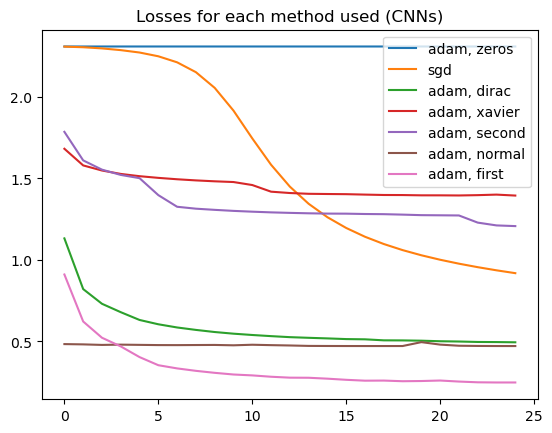

In [84]:
# Plot every loss trained on CNN
fig, ax = plt.subplots() 

ax.plot(losses['cnn zeros'], label='adam, zeros')

ax.plot(cnn_loss_sgd_1, label='sgd')
ax.plot(losses['cnn dirac'], label='adam, dirac')
ax.plot(losses['xavier'], label='adam, xavier')
ax.plot(cnn_loss2, label='adam, second')

ax.plot(losses['cnn normal'], label='adam, normal')

ax.plot(cnn_loss1, label='adam, first')

ax.set_title("Losses for each method used (CNNs)")

plt.legend()
plt.show()

Text(0.5, 1.0, 'Loss of SGD-trained CNN')

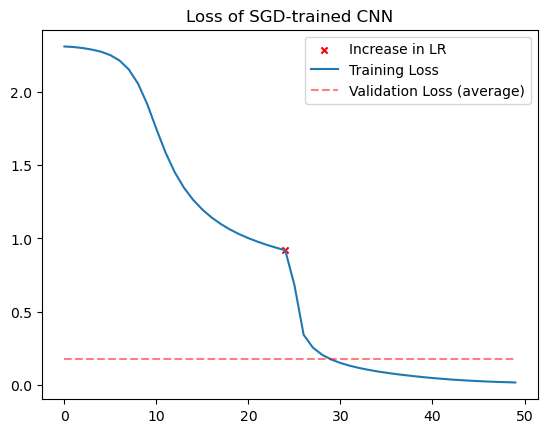

In [75]:
fig, ax = plt.subplots()

ax.scatter(24, cnn_loss_sgd_1[24], marker='x', color='red', label="Increase in LR", s = 20)
ax.plot(cnn_loss_sgd := np.concatenate([cnn_loss_sgd_1, cnn_loss_sgd_2]), label="Training Loss")
ax.plot([test_loss] * cnn_loss_sgd.shape[0], label="Validation Loss (average)", alpha=0.5, color="red", linestyle="--")

ax.legend()
ax.set_title("Loss of SGD-trained CNN")

EVALUATING MODEL


  0%|          | 0/329 [00:00<?, ?it/s]

100%|██████████| 329/329 [00:04<00:00, 68.47it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 69.63it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:24<00:00, 403.85it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9943179971158326
MODEL PRECISION: 0.9943440409373409
MODEL RECALL: 0.9943071017247529

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9565041369920164
MODEL PRECISION: 0.9565850742487966
MODEL RECALL: 0.9565400203314882

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9014979840008956
MODEL PRECISION: 0.9022392857675573
MODEL RECALL: 0.9015000000000001



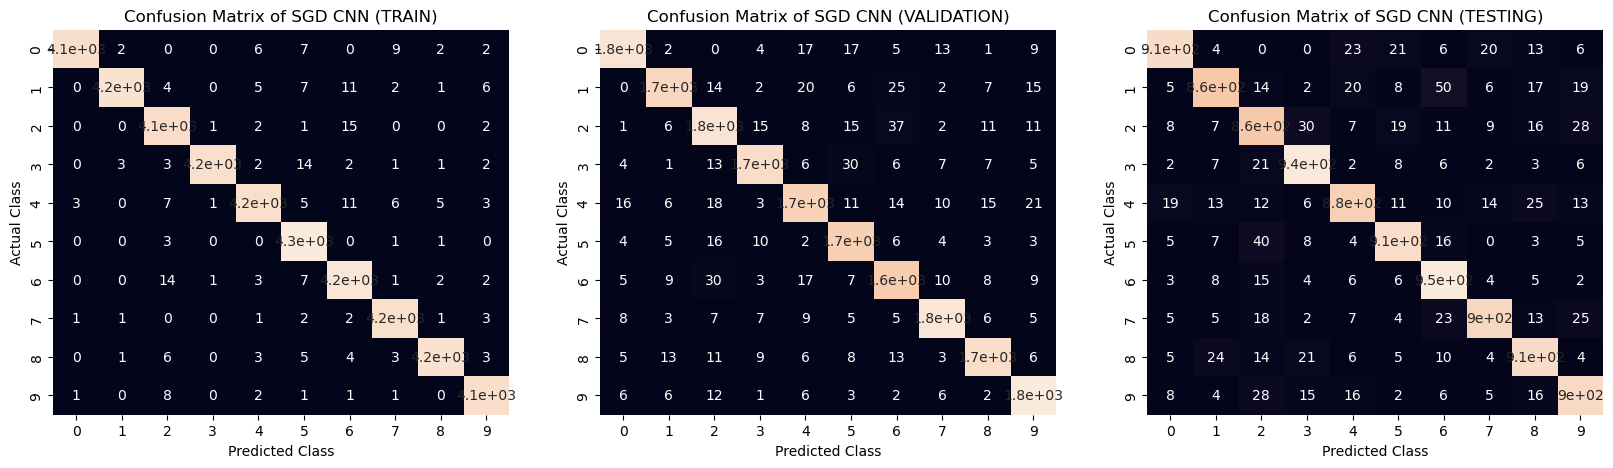

In [76]:
model_results(cnn_sgd, train_loader, val_loader, test_loader, data, "SGD CNN")

In [77]:
precisions = macro_precision(val_model(cnn_sgd, val_loader, data), get_avg=False)
recalls = macro_recall(val_model(cnn_sgd, val_loader, data), get_avg=False)
cats = data.targets.unique()

EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 65.12it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 71.52it/s]


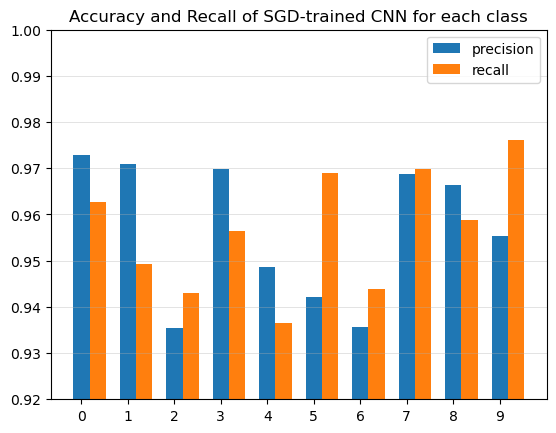

In [78]:
fig, ax = plt.subplots()

w = 0.35
ax.bar(cats, precisions, width=w, label='precision')
ax.bar(cats+w, recalls, width=w, label='recall')

ax.legend()

plt.grid(True, 'major', 'y', ls='-', lw=.5, alpha=.5)

ax.set_ylim(0.92, 1)
ax.set_xticks(cats)
ax.set_title("Accuracy and Recall of SGD-trained CNN for each class")

plt.show()

In [ ]:
# Conclusion: Overfit as on validation and testing the performance is significantly lower.
# For performance metric, precision is still OK as recall is more or less the same; infact F1-score is more or less the same

# Modelling Again: Try Dropout regularization

### FCNNN

In [79]:
fcnn_dropout = FCNN(regularize=True, regularize_param=0.5) 

In [82]:
fcnn_adam_dropout = torch.optim.Adam(fcnn_dropout.parameters())
loss_dropout = train_model(fcnn_dropout, 25, train_loader, CE, fcnn_adam_dropout)
save_model(fcnn_adam_dropout, loss_dropout, "fcnn_adam_dropout")

TRAINING MODEL!


329it [00:05, 55.35it/s]


Epoch: 1 | Loss: 0.1393 | Train Accuracy: 95.9413 | Time: 5.95


329it [00:05, 57.24it/s]


Epoch: 2 | Loss: 0.1217 | Train Accuracy: 96.3724 | Time: 5.75


329it [00:05, 57.15it/s]


Epoch: 3 | Loss: 0.1082 | Train Accuracy: 96.8798 | Time: 5.76


329it [00:05, 57.21it/s]


Epoch: 4 | Loss: 0.1028 | Train Accuracy: 96.9989 | Time: 5.75


329it [00:05, 56.48it/s]


Epoch: 5 | Loss: 0.0928 | Train Accuracy: 97.2966 | Time: 5.83


329it [00:05, 56.83it/s]


Epoch: 6 | Loss: 0.0904 | Train Accuracy: 97.3704 | Time: 5.79


329it [00:05, 57.03it/s]


Epoch: 7 | Loss: 0.0823 | Train Accuracy: 97.6658 | Time: 5.77


329it [00:05, 56.94it/s]


Epoch: 8 | Loss: 0.0751 | Train Accuracy: 97.8611 | Time: 5.78


329it [00:05, 55.15it/s]


Epoch: 9 | Loss: 0.0714 | Train Accuracy: 98.0564 | Time: 5.97


329it [00:05, 54.84it/s]


Epoch: 10 | Loss: 0.0699 | Train Accuracy: 98.0207 | Time: 6.00


329it [00:06, 54.72it/s]


Epoch: 11 | Loss: 0.0673 | Train Accuracy: 98.1088 | Time: 6.02


329it [00:06, 53.72it/s]


Epoch: 12 | Loss: 0.0609 | Train Accuracy: 98.3017 | Time: 6.13


329it [00:05, 55.45it/s]


Epoch: 13 | Loss: 0.0568 | Train Accuracy: 98.3756 | Time: 5.94


329it [00:06, 54.52it/s]


Epoch: 14 | Loss: 0.0611 | Train Accuracy: 98.3422 | Time: 6.04


329it [00:05, 54.91it/s]


Epoch: 15 | Loss: 0.0592 | Train Accuracy: 98.3970 | Time: 6.00


329it [00:05, 56.49it/s]


Epoch: 16 | Loss: 0.0517 | Train Accuracy: 98.5637 | Time: 5.83


329it [00:05, 55.98it/s]


Epoch: 17 | Loss: 0.0526 | Train Accuracy: 98.5780 | Time: 5.88


329it [00:05, 55.77it/s]


Epoch: 18 | Loss: 0.0499 | Train Accuracy: 98.6852 | Time: 5.90


329it [00:05, 57.12it/s]


Epoch: 19 | Loss: 0.0460 | Train Accuracy: 98.8115 | Time: 5.76


329it [00:05, 57.10it/s]


Epoch: 20 | Loss: 0.0488 | Train Accuracy: 98.7138 | Time: 5.77


329it [00:05, 57.42it/s]


Epoch: 21 | Loss: 0.0467 | Train Accuracy: 98.7710 | Time: 5.73


329it [00:05, 56.96it/s]


Epoch: 22 | Loss: 0.0483 | Train Accuracy: 98.7400 | Time: 5.78


329it [00:06, 53.40it/s]


Epoch: 23 | Loss: 0.0401 | Train Accuracy: 99.0401 | Time: 6.17


329it [00:05, 57.70it/s]


Epoch: 24 | Loss: 0.0434 | Train Accuracy: 98.9043 | Time: 5.71


329it [00:05, 57.67it/s]

Epoch: 25 | Loss: 0.0404 | Train Accuracy: 99.0091 | Time: 5.71


1

EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 69.08it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 69.83it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:22<00:00, 436.95it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9984082532656353
MODEL PRECISION: 0.9984244432935228
MODEL RECALL: 0.9983975253648497

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9691312669208646
MODEL PRECISION: 0.9692593028114119
MODEL RECALL: 0.969253845759696

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.924097370872936
MODEL PRECISION: 0.9254062360958735
MODEL RECALL: 0.9240999999999999



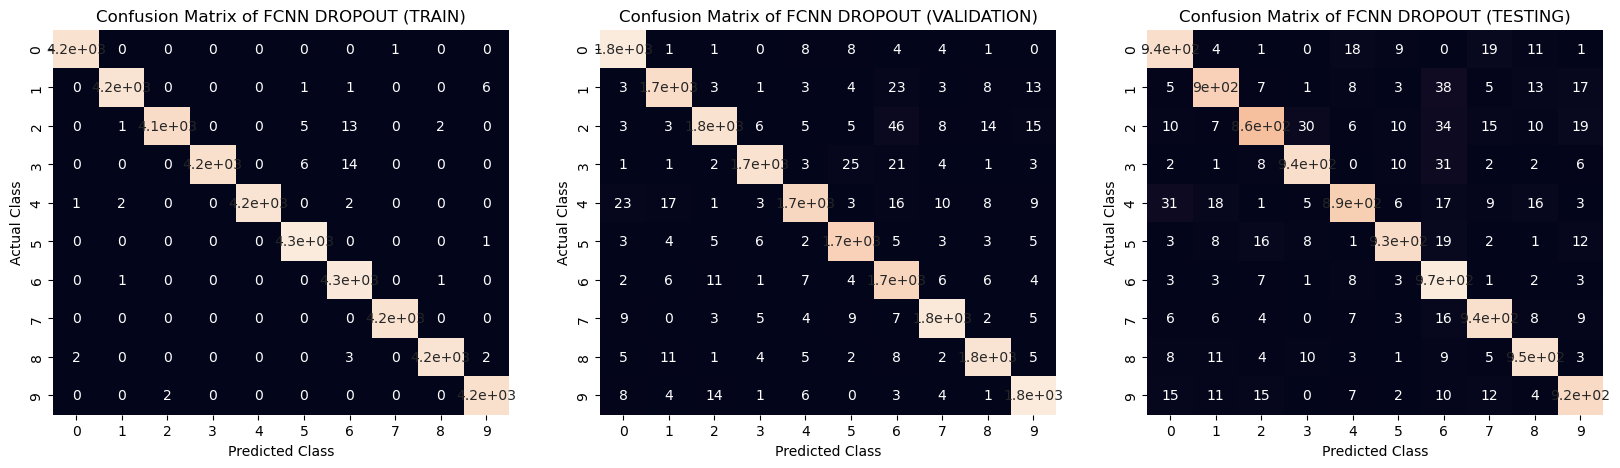

In [85]:
model_results(fcnn_dropout, train_loader, val_loader, test_loader, data, 'FCNN DROPOUT')

EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 67.50it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 67.68it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:24<00:00, 406.32it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9961959454818071
MODEL PRECISION: 0.9961881369405301
MODEL RECALL: 0.9962133357490046

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9595338118802799
MODEL PRECISION: 0.9598577895828366
MODEL RECALL: 0.9594467316560132

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9087640592356507
MODEL PRECISION: 0.909839206407956
MODEL RECALL: 0.9089



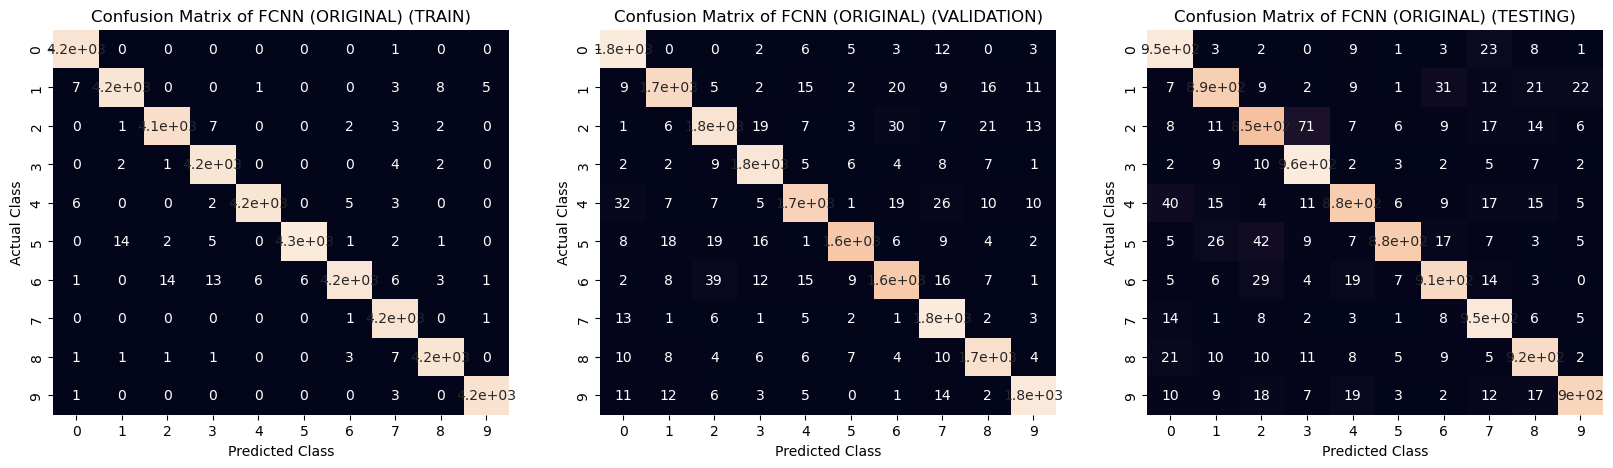

In [86]:
model_results(first_fcnn, train_loader, val_loader, test_loader, data, 'FCNN (ORIGINAL)')

### CNN

In [ ]:
cnn_dropout = CNN(regularize=True, regularize_param=0.5)
cnn_sgd_dropout = torch.optim.SGD(cnn_dropout.parameters())
loss_dropout_cnn = train_model(cnn_dropout, 25, train_loader, CE, cnn_sgd_dropout)

save_model(cnn_dropout, loss_dropout_cnn, "cnn_sgd_dropout_part1")

cnn_sgd_dropout_2 = torch.optim.SGD(cnn_dropout.parameters(), lr=0.05)
loss_dropout_cnn_2 = train_model(cnn_dropout, 25, train_loader, CE, cnn_sgd_dropout_2)

save_model(cnn_dropout, loss_dropout_cnn_2, "cnn_sgd_dropout_part2")


TRAINING MODEL!


329it [00:04, 66.31it/s]


Epoch: 1 | Loss: 2.3124 | Train Accuracy: 9.9419 | Time: 4.97


329it [00:04, 67.75it/s]


Epoch: 2 | Loss: 2.3084 | Train Accuracy: 11.1114 | Time: 4.86


329it [00:04, 67.76it/s]


Epoch: 3 | Loss: 2.3040 | Train Accuracy: 12.6286 | Time: 4.86


329it [00:04, 67.46it/s]


Epoch: 4 | Loss: 2.2985 | Train Accuracy: 14.6985 | Time: 4.88


329it [00:04, 66.61it/s]


Epoch: 5 | Loss: 2.2919 | Train Accuracy: 17.0756 | Time: 4.94


329it [00:04, 67.55it/s]


Epoch: 6 | Loss: 2.2827 | Train Accuracy: 20.0958 | Time: 4.88


329it [00:04, 67.55it/s]


Epoch: 7 | Loss: 2.2705 | Train Accuracy: 22.9945 | Time: 4.87


329it [00:05, 65.78it/s]


Epoch: 8 | Loss: 2.2528 | Train Accuracy: 26.3791 | Time: 5.00


329it [00:04, 66.44it/s]


Epoch: 9 | Loss: 2.2287 | Train Accuracy: 29.0206 | Time: 4.95


329it [00:04, 66.86it/s]


Epoch: 10 | Loss: 2.1961 | Train Accuracy: 31.8979 | Time: 4.92


329it [00:04, 66.83it/s]


Epoch: 11 | Loss: 2.1501 | Train Accuracy: 35.2539 | Time: 4.93


329it [00:05, 63.92it/s]


Epoch: 12 | Loss: 2.0898 | Train Accuracy: 37.9144 | Time: 5.15


329it [00:05, 65.19it/s]


Epoch: 13 | Loss: 2.0177 | Train Accuracy: 41.4658 | Time: 5.05


329it [00:05, 65.68it/s]


Epoch: 14 | Loss: 1.9383 | Train Accuracy: 44.8647 | Time: 5.01


329it [00:04, 66.94it/s]


Epoch: 15 | Loss: 1.8629 | Train Accuracy: 47.1989 | Time: 4.92


329it [00:04, 66.18it/s]


Epoch: 16 | Loss: 1.7873 | Train Accuracy: 49.1449 | Time: 4.97


329it [00:05, 63.20it/s]


Epoch: 17 | Loss: 1.6800 | Train Accuracy: 50.4573 | Time: 5.21


329it [00:05, 63.26it/s]


Epoch: 18 | Loss: 1.5823 | Train Accuracy: 52.7320 | Time: 5.20


329it [00:05, 63.57it/s]


Epoch: 19 | Loss: 1.5067 | Train Accuracy: 55.2925 | Time: 5.18


329it [00:05, 62.69it/s]


Epoch: 20 | Loss: 1.4498 | Train Accuracy: 57.0908 | Time: 5.25


329it [00:05, 63.12it/s]


Epoch: 21 | Loss: 1.4038 | Train Accuracy: 58.0864 | Time: 5.22


329it [00:05, 62.49it/s]


Epoch: 22 | Loss: 1.3638 | Train Accuracy: 59.2797 | Time: 5.27


329it [00:05, 63.88it/s]


Epoch: 23 | Loss: 1.3317 | Train Accuracy: 59.8514 | Time: 5.16


329it [00:05, 64.36it/s]


Epoch: 24 | Loss: 1.2326 | Train Accuracy: 62.8168 | Time: 5.12


329it [00:05, 61.86it/s]


Epoch: 25 | Loss: 1.1556 | Train Accuracy: 65.4487 | Time: 5.32
TRAINING MODEL!


329it [00:05, 58.72it/s]


Epoch: 1 | Loss: 0.8977 | Train Accuracy: 72.1751 | Time: 5.61


329it [00:05, 65.44it/s]


Epoch: 2 | Loss: 0.6302 | Train Accuracy: 80.1853 | Time: 5.03


329it [00:04, 67.57it/s]


Epoch: 3 | Loss: 0.5169 | Train Accuracy: 83.6938 | Time: 4.87


329it [00:04, 66.10it/s]


Epoch: 4 | Loss: 0.4532 | Train Accuracy: 85.9256 | Time: 4.98


329it [00:05, 64.84it/s]


Epoch: 5 | Loss: 0.4117 | Train Accuracy: 87.2547 | Time: 5.08


329it [00:05, 62.20it/s]


Epoch: 6 | Loss: 0.3793 | Train Accuracy: 88.1812 | Time: 5.29


329it [00:05, 65.53it/s]


Epoch: 7 | Loss: 0.3510 | Train Accuracy: 89.1554 | Time: 5.03


329it [00:04, 66.09it/s]


Epoch: 8 | Loss: 0.3320 | Train Accuracy: 89.8533 | Time: 4.98


329it [00:05, 61.77it/s]


Epoch: 9 | Loss: 0.3159 | Train Accuracy: 90.2510 | Time: 5.33


329it [00:05, 64.97it/s]


Epoch: 10 | Loss: 0.3076 | Train Accuracy: 90.5107 | Time: 5.07


329it [00:05, 65.32it/s]


Epoch: 11 | Loss: 0.2900 | Train Accuracy: 91.0942 | Time: 5.04


329it [00:04, 66.11it/s]


Epoch: 12 | Loss: 0.2793 | Train Accuracy: 91.4968 | Time: 4.98


329it [00:05, 65.21it/s]


Epoch: 13 | Loss: 0.2719 | Train Accuracy: 91.7349 | Time: 5.05


329it [00:05, 65.45it/s]


Epoch: 14 | Loss: 0.2663 | Train Accuracy: 91.8898 | Time: 5.03


329it [00:05, 63.63it/s]


Epoch: 15 | Loss: 0.2575 | Train Accuracy: 92.1280 | Time: 5.17


329it [00:05, 64.79it/s]


Epoch: 16 | Loss: 0.2515 | Train Accuracy: 92.3518 | Time: 5.08


329it [00:05, 64.17it/s]


Epoch: 17 | Loss: 0.2452 | Train Accuracy: 92.5162 | Time: 5.13


329it [00:04, 66.13it/s]


Epoch: 18 | Loss: 0.2348 | Train Accuracy: 92.8568 | Time: 4.98


329it [00:05, 65.68it/s]


Epoch: 19 | Loss: 0.2370 | Train Accuracy: 92.7568 | Time: 5.01


329it [00:04, 66.55it/s]


Epoch: 20 | Loss: 0.2300 | Train Accuracy: 92.9545 | Time: 4.95


329it [00:04, 67.23it/s]


Epoch: 21 | Loss: 0.2209 | Train Accuracy: 93.3189 | Time: 4.90


329it [00:04, 66.90it/s]


Epoch: 22 | Loss: 0.2254 | Train Accuracy: 93.1474 | Time: 4.92


329it [00:04, 66.44it/s]


Epoch: 23 | Loss: 0.2158 | Train Accuracy: 93.3618 | Time: 4.96


329it [00:04, 66.05it/s]


Epoch: 24 | Loss: 0.2084 | Train Accuracy: 93.5999 | Time: 4.98


329it [00:04, 67.04it/s]

Epoch: 25 | Loss: 0.2088 | Train Accuracy: 93.5809 | Time: 4.91


1

EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 71.34it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 73.35it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:25<00:00, 399.59it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.978529269180265
MODEL PRECISION: 0.9787426614405248
MODEL RECALL: 0.9784862523873507

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9607723669904438
MODEL PRECISION: 0.9609939614544551
MODEL RECALL: 0.9608274822444207

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9028534036541146
MODEL PRECISION: 0.9045648091671611
MODEL RECALL: 0.9029999999999999



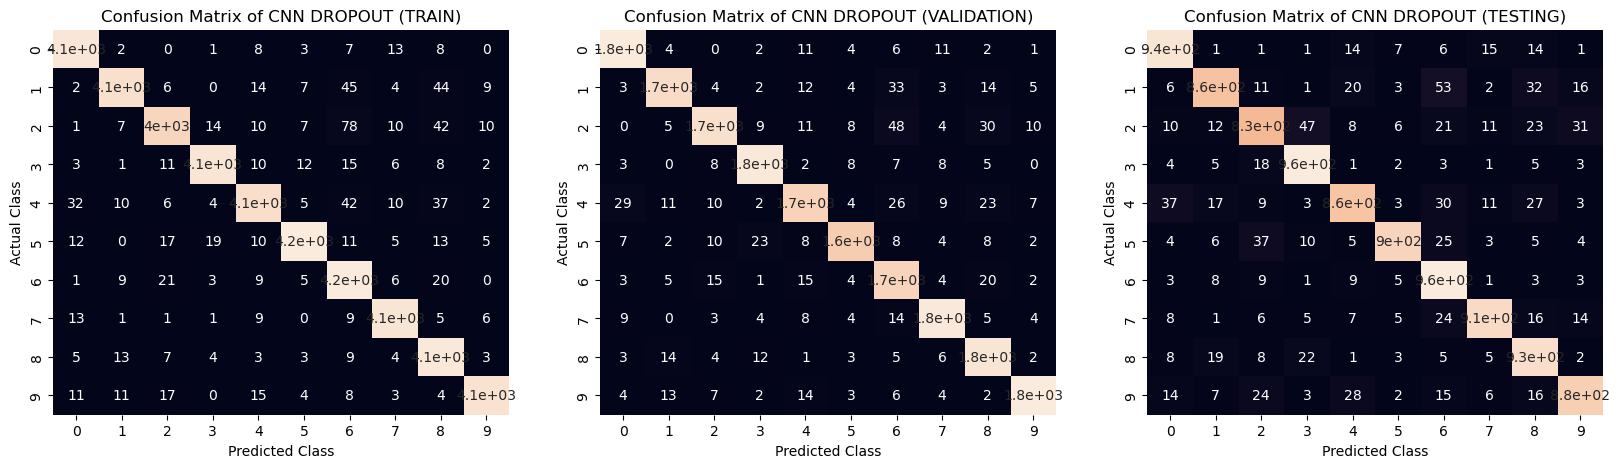

In [98]:
model_results(cnn_dropout, train_loader, val_loader, test_loader, data, 'CNN DROPOUT')

EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 69.71it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 70.71it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:25<00:00, 398.14it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9943179971158326
MODEL PRECISION: 0.9943440409373409
MODEL RECALL: 0.9943071017247529

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9565041369920164
MODEL PRECISION: 0.9565850742487966
MODEL RECALL: 0.9565400203314882

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9014979840008956
MODEL PRECISION: 0.9022392857675573
MODEL RECALL: 0.9015000000000001



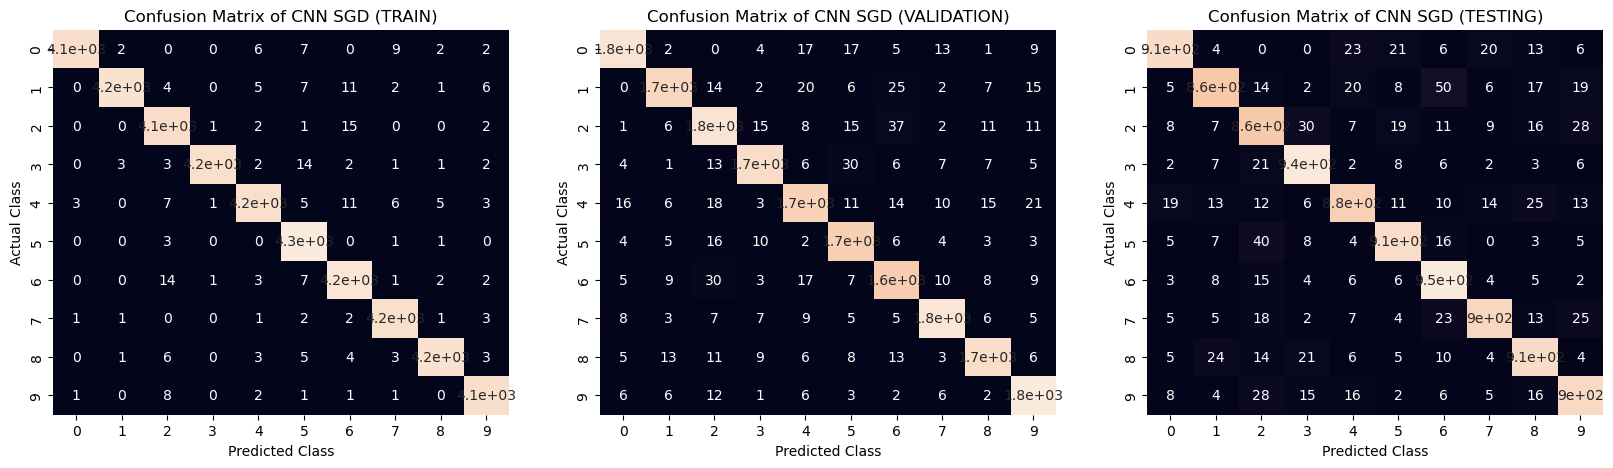

In [99]:
model_results(cnn_sgd, train_loader, val_loader, test_loader, data, 'CNN SGD')

## Fine Tuning Best Model with Large Dropout (p=0.8)
Insipired by https://arxiv.org/pdf/2403.00946

### CNN

In [100]:
# load incase we do not have my_cnn (see model training)
my_cnn = CNN()

my_cnn.load_state_dict(torch.load('./weights/cnn_sgd_part2'))

<All keys matched successfully>

In [101]:
cnn_dropout_finetuning = CNN(regularize=True, regularize_param = 0.8, fine_tuning=True)

cnn_dropout_finetuning.load_state_dict(my_cnn.state_dict())


<All keys matched successfully>

In [102]:
cnn_sgd_dropout_finetuning = torch.optim.SGD(cnn_dropout_finetuning.parameters(), 0.05)
loss_dropout_cnn_finetuning = train_model(cnn_dropout_finetuning, 10, train_loader, CE, cnn_sgd_dropout_finetuning)

TRAINING MODEL!


329it [00:05, 62.89it/s]


Epoch: 1 | Loss: 1.2098 | Train Accuracy: 65.2129 | Time: 5.23


329it [00:04, 65.83it/s]


Epoch: 2 | Loss: 0.8023 | Train Accuracy: 75.2382 | Time: 5.00


329it [00:05, 65.72it/s]


Epoch: 3 | Loss: 0.7095 | Train Accuracy: 78.0226 | Time: 5.01


329it [00:04, 66.37it/s]


Epoch: 4 | Loss: 0.6430 | Train Accuracy: 79.8471 | Time: 4.96


329it [00:04, 66.38it/s]


Epoch: 5 | Loss: 0.5939 | Train Accuracy: 81.3786 | Time: 4.96


329it [00:04, 67.50it/s]


Epoch: 6 | Loss: 0.5682 | Train Accuracy: 82.3028 | Time: 4.88


329it [00:05, 65.73it/s]


Epoch: 7 | Loss: 0.5397 | Train Accuracy: 83.1936 | Time: 5.01


329it [00:04, 67.13it/s]


Epoch: 8 | Loss: 0.5174 | Train Accuracy: 83.7795 | Time: 4.90


329it [00:05, 65.51it/s]


Epoch: 9 | Loss: 0.4999 | Train Accuracy: 84.5203 | Time: 5.02


329it [00:04, 66.66it/s]


Epoch: 10 | Loss: 0.4853 | Train Accuracy: 85.0562 | Time: 4.94


In [103]:
save_model(cnn_sgd_dropout_finetuning, loss_dropout_cnn_finetuning, "cnn_dropout_finetuning")

1

EVALUATING MODEL


  0%|          | 0/329 [00:00<?, ?it/s]

100%|██████████| 329/329 [00:04<00:00, 69.85it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 71.97it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:26<00:00, 371.54it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9404710234864029
MODEL PRECISION: 0.9413309489664824
MODEL RECALL: 0.9403345574229037

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9274885694921002
MODEL PRECISION: 0.9282066299190058
MODEL RECALL: 0.9277764635487802

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.8321728530117802
MODEL PRECISION: 0.8380738971340496
MODEL RECALL: 0.8319000000000001



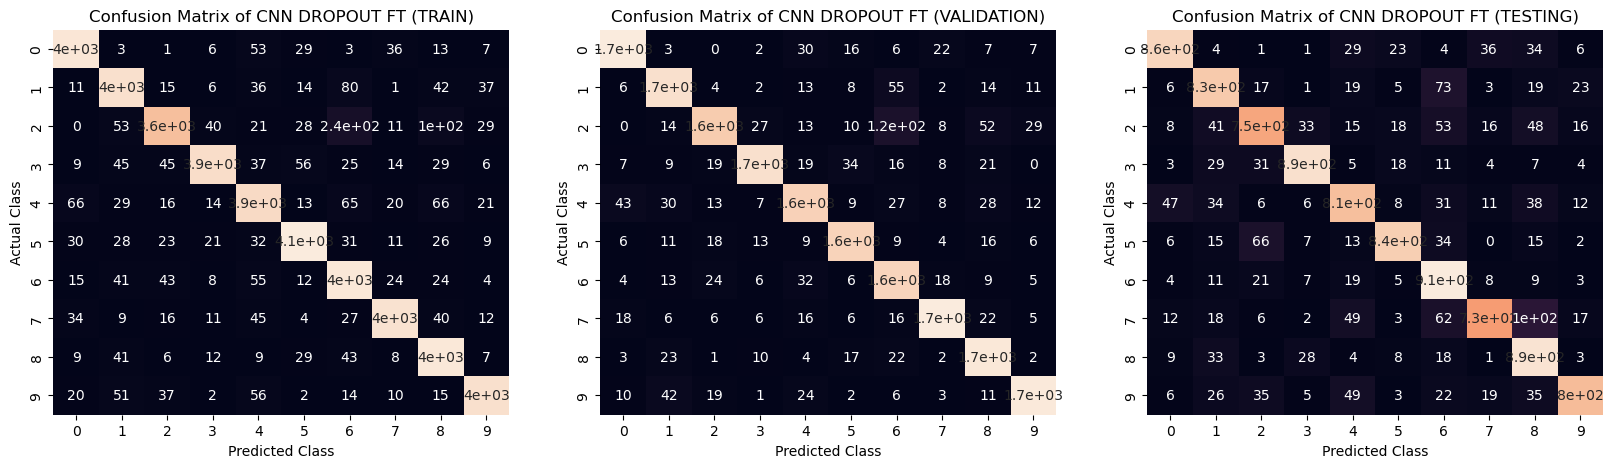

In [105]:
model_results(cnn_dropout_finetuning, train_loader, val_loader, test_loader, data, 'CNN DROPOUT FT')

EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 69.90it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 67.90it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:26<00:00, 379.64it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9943179971158326
MODEL PRECISION: 0.9943440409373409
MODEL RECALL: 0.9943071017247529

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9565041369920164
MODEL PRECISION: 0.9565850742487966
MODEL RECALL: 0.9565400203314882

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9014979840008956
MODEL PRECISION: 0.9022392857675573
MODEL RECALL: 0.9015000000000001



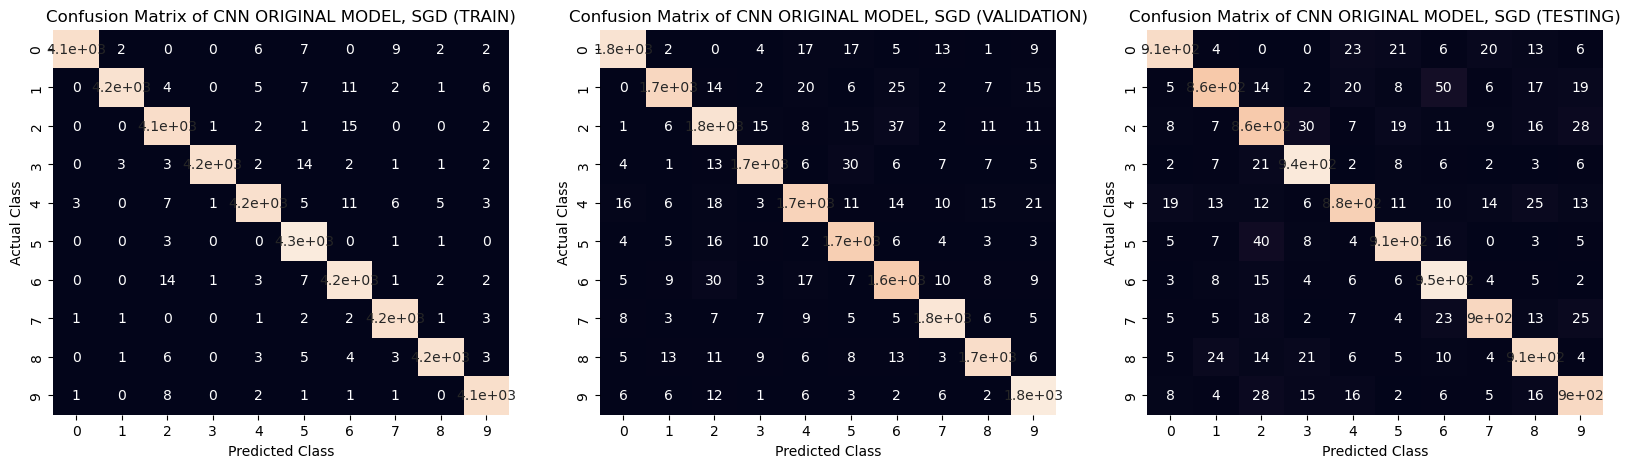

In [106]:
model_results(cnn_sgd, train_loader, val_loader, test_loader, data, 'CNN ORIGINAL MODEL, SGD')

### FCNN

In [108]:
fcnn_dropout_finetuning = FCNN(regularize = True,
                               regularize_param = 0.8,
                               fine_tuning = True)

fcnn_dropout_finetuning.load_state_dict(first_fcnn.state_dict())

<All keys matched successfully>

In [ ]:
fcnn_sgd_dropout_finetuning = torch.optim.SGD(fcnn_dropout_finetuning.parameters(), 0.05)
loss_dropout_fcnn_finetuning = train_model(fcnn_dropout_finetuning, 10, train_loader, CE, fcnn_sgd_dropout_finetuning)


TRAINING MODEL!


329it [00:05, 61.37it/s]


Epoch: 1 | Loss: 0.0086 | Train Accuracy: 100.0357 | Time: 5.36


329it [00:05, 61.92it/s]


Epoch: 2 | Loss: 0.0027 | Train Accuracy: 100.2120 | Time: 5.32


329it [00:05, 61.71it/s]


Epoch: 3 | Loss: 0.0019 | Train Accuracy: 100.2596 | Time: 5.34


329it [00:05, 63.09it/s]


Epoch: 4 | Loss: 0.0013 | Train Accuracy: 100.2668 | Time: 5.22


329it [00:05, 61.85it/s]


Epoch: 5 | Loss: 0.0009 | Train Accuracy: 100.2882 | Time: 5.32


329it [00:05, 58.86it/s]


Epoch: 6 | Loss: 0.0006 | Train Accuracy: 100.2977 | Time: 5.59


329it [00:05, 58.90it/s]


Epoch: 7 | Loss: 0.0005 | Train Accuracy: 100.2930 | Time: 5.59


329it [00:05, 55.61it/s]


Epoch: 8 | Loss: 0.0006 | Train Accuracy: 100.2906 | Time: 5.92


329it [00:06, 53.80it/s]


Epoch: 9 | Loss: 0.0004 | Train Accuracy: 100.2977 | Time: 6.12


329it [00:05, 58.30it/s]

Epoch: 10 | Loss: 0.0004 | Train Accuracy: 100.2954 | Time: 5.65


In [112]:
save_model(fcnn_sgd_dropout_finetuning, loss_dropout_fcnn_finetuning, "fcnn_dropout_finetuning")


1

EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 66.47it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 68.92it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:25<00:00, 387.24it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 1.0
MODEL PRECISION: 1.0
MODEL RECALL: 1.0

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9656349345299876
MODEL PRECISION: 0.9657446358732296
MODEL RECALL: 0.9655963214269352

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9190891086628141
MODEL PRECISION: 0.919899335496112
MODEL RECALL: 0.9190999999999999



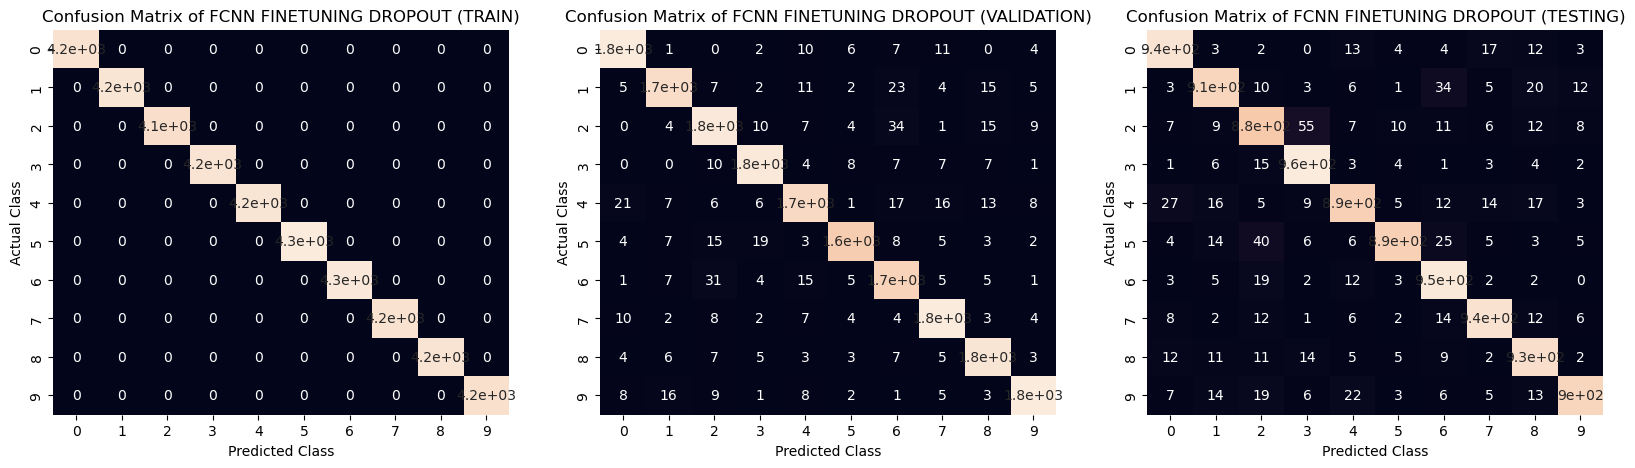

In [110]:
model_results(fcnn_dropout_finetuning, train_loader, val_loader, test_loader, data, 'FCNN FINETUNING DROPOUT')

In [111]:
model_results(first_fcnn, train_loader, val_loader, test_loader, data, 'ORIGINAL FCNN')

EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 66.92it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 64.33it/s]


EVALUATING MODEL


 16%|█▌        | 1600/10000 [00:04<00:21, 392.91it/s]


KeyboardInterrupt: 